In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Cargar dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Convertir a DataFrames
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print(X.shape)                         # tamaño de dataset - caracteristicas
print(np.unique(y), data.target_names) # clases
print(np.bincount(y))                  # distribucion de clases
print(df.head())

(569, 30)
[0 1] ['malignant' 'benign']
[212 357]
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst textu

Prepocesamiento de datos

In [ ]:
# Estandarizar las caracteristicas
scaler = StandardScaler() # restar los valores medios de cada caracteristica y escalarlas para que tengan una desviacion estandar unitaria
X_scaled = scaler.fit_transform(X)

In [4]:
# Convertir a tensores de Pytorch
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.LongTensor(y)

Division de datos

In [5]:
# Crear dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Dividir datos
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

Definir el modelo MLP

In [7]:
# Definir MLP
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(MLPClassifier, self).__init__()

        # Capas ocultas
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size

        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size

        # Capa de salida
        self.output_layer = nn.Linear(prev_size, output_size)

        # Funciones de activacion y dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(size) for size in hidden_sizes])

    def forward(self, x):
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.batch_norms[i](x)
            x = self.relu(x)
            x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [8]:
# Instanciar el modelo
input_size = X.shape[1]
hidden_sizes = [64, 32, 16]
output_size = 2

model = MLPClassifier(input_size, hidden_sizes, output_size, dropout_rate=0.3)
model = model.to(device)
print(model)

MLPClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
# Configurar funcion de perdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Reducir learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [10]:
# Funcion para calcular accuracy
def accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

In [11]:
# Entrenamiento del modelo
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    # Fase de entrenamiento
    model.train()
    epoch_train_loss = 0
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Calcular metricas de entrenamiento
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = accuracy(train_loader, model)

    # Fase de validacion
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = accuracy(val_loader, model)

    # Actualizatr learning rate
    scheduler.step(avg_val_loss)

    # Guardar metricas
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping in epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}")

Epoch [10/100], Train Loss: 0.2240, Val Loss: 0.1256, Train Acc: 97.24, Val Acc: 100.00
Epoch [20/100], Train Loss: 0.2243, Val Loss: 0.0670, Train Acc: 98.24, Val Acc: 97.65
Epoch [30/100], Train Loss: 0.1156, Val Loss: 0.0417, Train Acc: 98.49, Val Acc: 100.00
Epoch [40/100], Train Loss: 0.1121, Val Loss: 0.0476, Train Acc: 98.74, Val Acc: 97.65
Epoch [50/100], Train Loss: 0.1007, Val Loss: 0.0302, Train Acc: 98.74, Val Acc: 100.00
Epoch [60/100], Train Loss: 0.0577, Val Loss: 0.0264, Train Acc: 99.25, Val Acc: 100.00
Early stopping in epoch 63


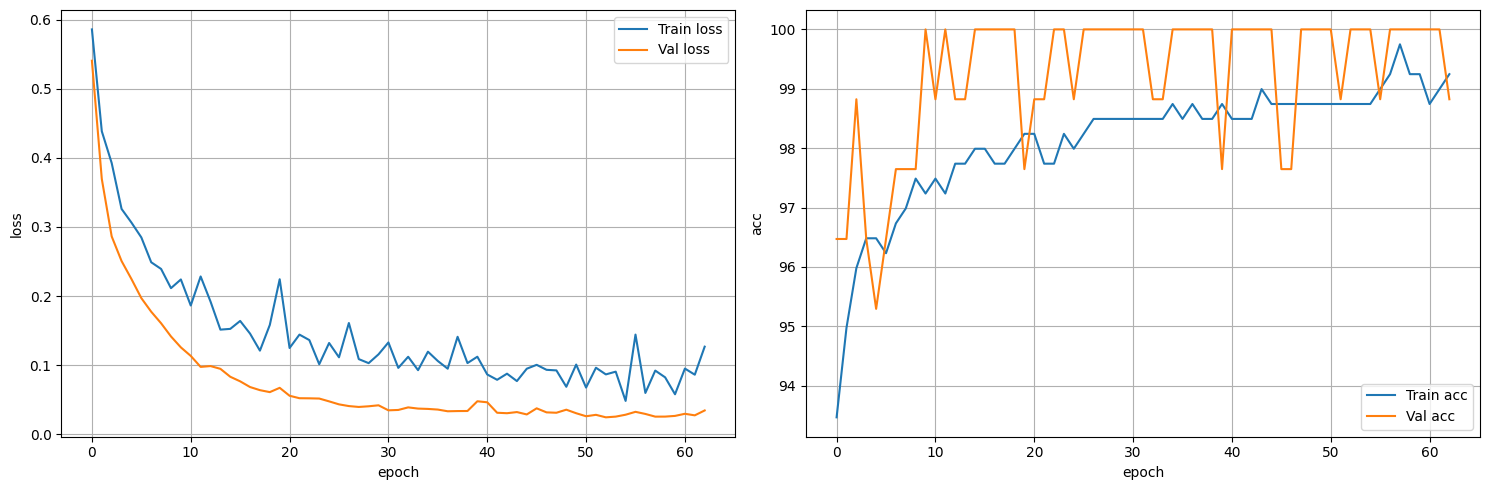

In [12]:
# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))

plt.figure(figsize=(15, 5))
# Visualizar el progreso del entrenamiento
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train acc')
plt.plot(val_accuracies, label='Val acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Train loss: desciende rapidamente y se estabiliza al redededor de 0.1
- Val loss: Sigue una trayectoria similar a "train loss", estabilizandose al rededor de +0.0 - 0.1
- Ambas curvas convergen sin divergencias
- No hay overfitting: la perdidad de validacion no aumenta mientras el train loss disminuye

In [13]:
# Evaluacion en el conjunto de prueba
test_accuracy = accuracy(test_loader, model)
print(f"Test acc: {test_accuracy:.2f}")

Test acc: 96.51


In [14]:
# Calcular predicciones para la matriz de confusion
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

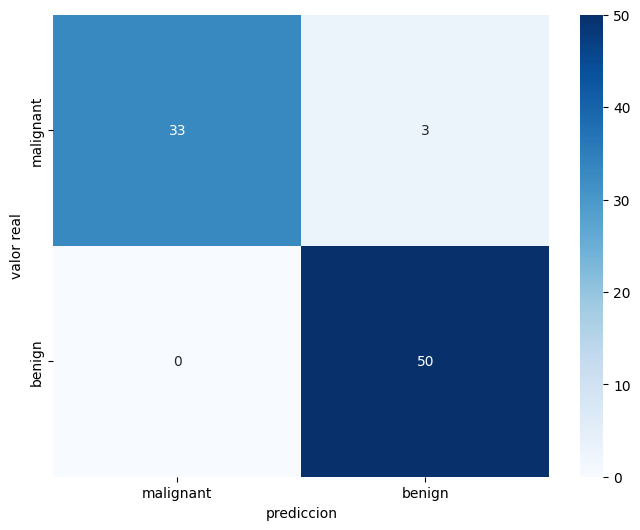

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusion
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.xlabel('prediccion')
plt.ylabel('valor real')
plt.show()

- El modelo distingue excelentemente entre tumores malignos y benignos.
-                           prediccion
-                       maligno     benigno
-       real maligno       TP          FN
-       real benigno       FP          TN 

- TP: el modelo predijo maligno y era maligno (33)
- FP: el modelo predijo maligno pero benigno (0)
- FN: el modelo predijo benigno pero era maligno (3)
- TN: el modelo predijo benigno y era benigno (50)